# Importing librays

In [58]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

# Loading dataset

In [55]:
train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train.csv")
test = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test.csv")

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
print("Shape of train set: ", train.shape, '\n'
      "Shape of test set: ", test.shape)

Shape of train set:  (27455, 785) 
Shape of test set:  (7172, 785)


# Check for corrupted data

In [5]:
print("Corrupted pixels and labels in train set: ", train.isna().sum().sum(), '\n'
        "Corrupted pixels and labels in test set: ", test.isna().sum().sum())

Corrupted pixels and labels in train set:  0 
Corrupted pixels and labels in test set:  0


# Data preprocessing

<AxesSubplot:xlabel='label', ylabel='count'>

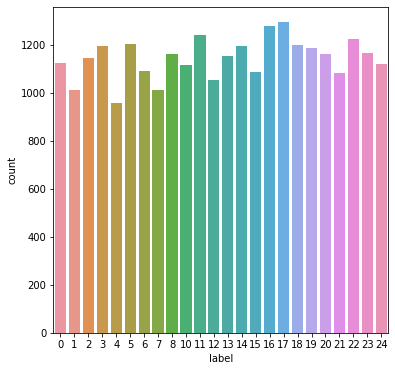

In [74]:
plt.figure(figsize = (6, 6))
sns.countplot(x = train['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

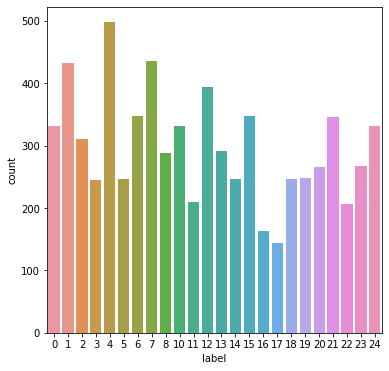

In [75]:
plt.figure(figsize = (6, 6))
sns.countplot(x = test['label'])

# Split dataset to XTrain, yTrain, XTest, yTest and y which we will use for confusion matrix

In [ ]:
dataset = train.append(test)

In [70]:
X = dataset.drop(['label'], axis = 1)
y = dataset['label']

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, train_size = 0.7, random_state = 21, shuffle = True)
y = yTest.copy()

<AxesSubplot:xlabel='label', ylabel='count'>

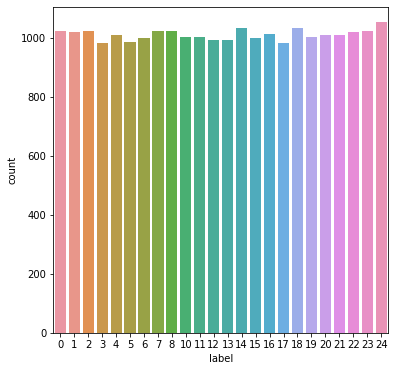

In [77]:
plt.figure(figsize = (6, 6))
sns.countplot(x = yTrain)

<AxesSubplot:xlabel='label', ylabel='count'>

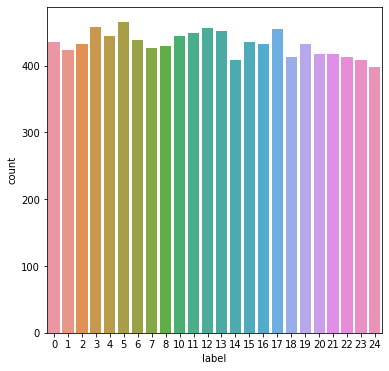

In [78]:
plt.figure(figsize = (6, 6))
sns.countplot(x = yTest)

# Convert yTrain and yTest to one hot representation for softmax

In [79]:
numClasses = len(yTrain.unique()) + 1 # Dataset is missing class 9

In [80]:
yTrain = to_categorical(yTrain, numClasses)
yTest = to_categorical(yTest, numClasses)

# Data normalization

In [81]:
XTrain = XTrain / 255.0
XTest = XTest / 255.0

# Convert XTrain and XTest to (numberOfTrainingExamples x imageShape) where image shape is (28 x 28 x 1). 1 becouse our images are in grayscale

In [82]:
XTrain = np.array(XTrain).reshape(-1, 28, 28, 1)
XTest = np.array(XTest).reshape(-1, 28, 28, 1)

# Lets plot some training examples

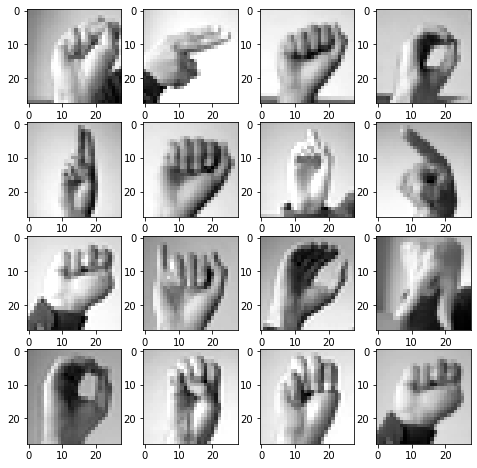

In [101]:
fig = plt.figure(figsize = (8, 8))
rows, columns = 4, 4

for i in range(1, (rows * columns) + 1):
    imageIndex = np.random.randint(0, XTrain.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(XTrain[imageIndex], cmap = 'gray')
    
plt.show()


# Training the model

### Data augmentation

In [102]:
dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=14,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.09, # Randomly zoom image 
        width_shift_range=0.14,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.14,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        brightness_range = (0.8, 1.0),  # brightness of image
        rescale = 1 / 255.0)  # Normalization output
                                
dataGenerator.fit(XTrain)

### Early stopping

In [103]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs = None): 
        if(logs.get('val_accuracy') >= self.threshold):
            print("Reached", self.threshold, "% accuracy. Stopping learning!")
            self.model.stop_training = True
            
earlyStopping = CustomEarlyStopping(0.997)

### Reduce learning rate

In [104]:
learningRateReduction = ReduceLROnPlateau(monitor='loss', patience = 1, verbose=1,factor=0.75, min_lr=0.00000000001)

### Before we start making the model, let's think about what we want to achieve. We need to find a golden mean between accuracy, model speed (total number of multiplications) and learning speed.
### In the model below, I care only about the accuracy and speed of the model.

In [105]:
model = Sequential()

model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (28,28,1)))
model.add(Dropout(0.05))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'valid'))

model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.15))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'valid'))

model.add(Conv2D(16, (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(Dropout(0.05))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 1, padding = 'valid'))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.05))
model.add(BatchNormalization())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.05))
model.add(BatchNormalization())

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.05))
model.add(BatchNormalization())

model.add(Dense(units = numClasses, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
dropout_41 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 14, 14, 32)       

In [106]:
history = model.fit(dataGenerator.flow(XTrain, yTrain, batch_size = 16) ,epochs = 80, 
                    validation_data = (XTest, yTest), callbacks = [learningRateReduction])

Epoch 1/80
1515/1515 [==============================] - 23s 14ms/step - loss: 1.4863 - accuracy: 0.5193 - val_loss: 1.4676 - val_accuracy: 0.5862
Epoch 2/80
1515/1515 [==============================] - 21s 14ms/step - loss: 0.6951 - accuracy: 0.7663 - val_loss: 0.4406 - val_accuracy: 0.8427
Epoch 3/80
1515/1515 [==============================] - 21s 14ms/step - loss: 0.5056 - accuracy: 0.8302 - val_loss: 0.3990 - val_accuracy: 0.8594
Epoch 4/80
1515/1515 [==============================] - 21s 14ms/step - loss: 0.4264 - accuracy: 0.8593 - val_loss: 1.5548 - val_accuracy: 0.6202
Epoch 5/80
1515/1515 [==============================] - 21s 14ms/step - loss: 0.3582 - accuracy: 0.8794 - val_loss: 0.3403 - val_accuracy: 0.8850
Epoch 6/80
1515/1515 [==============================] - 21s 14ms/step - loss: 0.3110 - accuracy: 0.8983 - val_loss: 0.1837 - val_accuracy: 0.9353
Epoch 7/80
1515/1515 [==============================] - 21s 14ms/step - loss: 0.2962 - accuracy: 0.9059 - val_loss: 0.1270 -

# Analysis

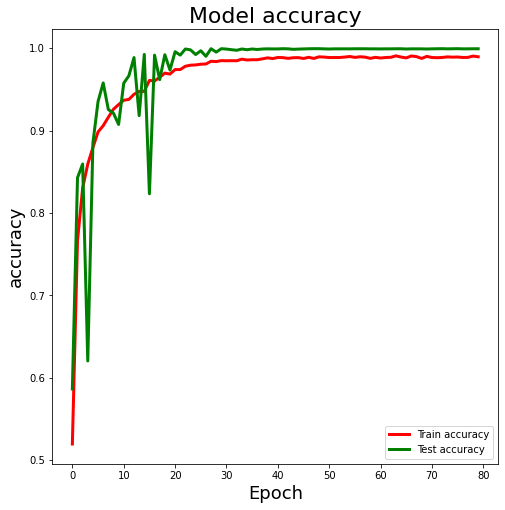

In [136]:
plt.figure(figsize = (8, 8))
plt.plot(history.history["accuracy"], color = 'red', linewidth = 3)
plt.plot(history.history["val_accuracy"], color = 'green', linewidth = 3)
plt.title("Model accuracy", fontsize = 22)
plt.ylabel("accuracy", fontsize = 18)
plt.xlabel("Epoch", fontsize = 18)
plt.legend(["Train accuracy", "Test accuracy"], loc = 'lower right')

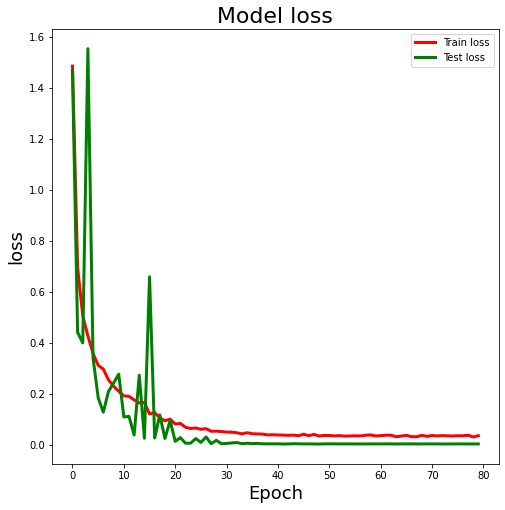

In [137]:
plt.figure(figsize = (8, 8))
plt.plot(history.history["loss"], color = 'red', linewidth = 3)
plt.plot(history.history["val_loss"], color = 'green', linewidth = 3)
plt.title("Model loss", fontsize = 22)
plt.ylabel("loss", fontsize = 18)
plt.xlabel("Epoch", fontsize = 18)
plt.legend(["Train loss", "Test loss"], loc = 'upper right')

<AxesSubplot:>

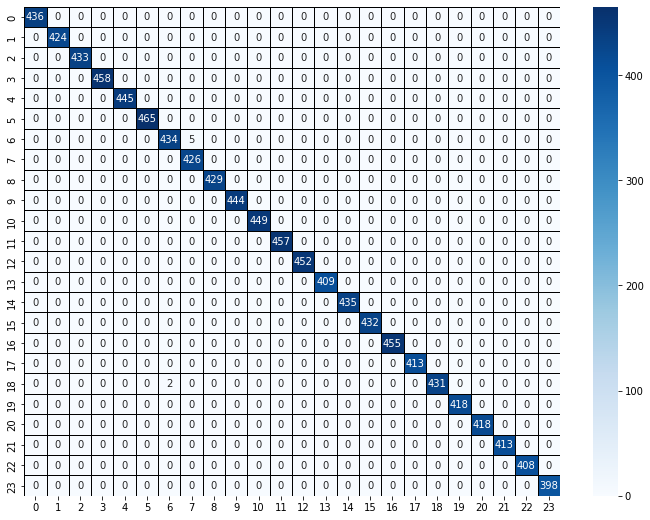

In [156]:
predictions = model.predict(XTest)
predictions = np.argmax(predictions, axis = 1)

confusionMatrix = confusion_matrix(y, predictions)

plt.figure(figsize = (12, 9))
sns.heatmap(confusionMatrix, cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='')

In [224]:
badlyClassified = np.where(predictions != y)

In [225]:
badlyClassified = np.array(badlyClassified).tolist()
badlyClassified = [item for sublist in badlyClassified for item in sublist]

[3075, 3405, 4930, 6055, 6182, 7579, 9105]

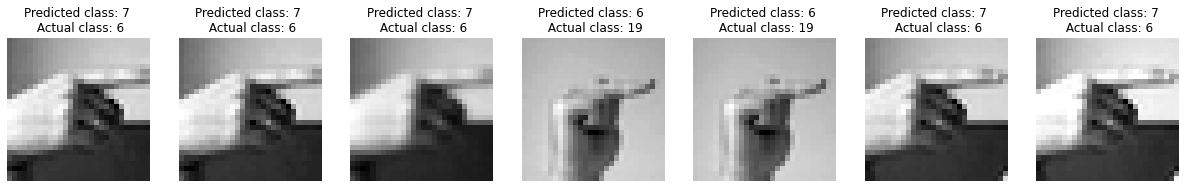

In [245]:
fig = plt.figure(figsize = (21, 21))
rows, columns = 1, 7

for i in range(0, len(badlyClassified)):
    fig.add_subplot(rows, columns,  i + 1)
    plt.axis('off')
    plt.title("Predicted class: {} \n Actual class: {}".format(predictions[badlyClassified[i]], np.argmax(yTest[badlyClassified[i]], axis = 0)))
    plt.imshow(XTest[badlyClassified[i]], cmap = 'gray')
    
plt.show()